In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, RocCurveDisplay, precision_recall_curve, f1_score, precision_score, recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib

In [2]:
data_dir = Path("../../data/processed")

figures_dir = Path("../../figures")
figures_dir.mkdir(parents=True, exist_ok=True)

models_dir = Path("../../trained_models")
models_dir.mkdir(parents=True, exist_ok=True)

In [3]:
features = [
    'credit_limit_used(%)', 
    'credit_score', 
    'prev_defaults', 
    'default_in_last_6months',
    'no_of_children', 
    'owns_car', 
    'no_of_days_employed',
    'yearly_debt_payments',
    'migrant_worker',
    'total_family_members',
    'credit_score_squared',
    'credit_limit_used_squared',
    'credit_score_x_credit_limit_used',
    'credit_ratio_limit'
]

In [4]:
df = pd.read_csv(data_dir / "imputed_dataset_with_synthetic.csv")

target = 'credit_card_default'

X = df[features]
y = df[target]

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [5]:
param_grid = {
    'n_estimators': [100, 200, 500, 800, 1000],         # more trees for stability
    'max_depth': [None, 5, 10, 15, 20, 25],             # deeper trees
    'min_samples_split': [2, 5, 10, 20],                # control node splitting
    'min_samples_leaf': [1, 2, 4, 8],                   # control leaf size
    'max_features': ['sqrt', 'log2', 0.5, None],        # sqrt/log2, half of features, all features
    'class_weight': ['balanced', 'balanced_subsample', None],  # handle class imbalance
    'bootstrap': [True, False],                         # whether to bootstrap samples
    'criterion': ['gini', 'entropy']                    # split quality measure
}

rf = RandomForestClassifier(random_state=42)

rf_random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=150,                        # limit candidates to reduce runtime
    scoring='f1',                     # optimize for F1 of the minority class
    n_jobs=-1,                        # use all cores
    cv=5,                             # 5-fold CV
    verbose=2,
    random_state=42
)

rf_random_search.fit(X_train, y_train)

print("Best parameters:", rf_random_search.best_params_)
print("Best F1 score on CV:", rf_random_search.best_score_)

best_rf = rf_random_search.best_estimator_

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': None, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}
Best F1 score on CV: 0.9772248872018057


In [6]:
y_pred = best_rf.predict(X_val)
y_prob = best_rf.predict_proba(X_val)[:,1]

print(classification_report(y_val, y_pred))

# ROC Curve
RocCurveDisplay.from_predictions(y_val, y_prob)
plt.title("Random Forest ROC Curve")
plt.savefig(figures_dir / "rf_roc_curve.png")
plt.close()

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_val, y_prob)
plt.figure()
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Random Forest Precision-Recall Curve')
plt.savefig(figures_dir / "rf_precision_recall_curve.png")
plt.close()

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      8366
         1.0       0.98      0.98      0.98      4677

    accuracy                           0.98     13043
   macro avg       0.98      0.98      0.98     13043
weighted avg       0.98      0.98      0.98     13043



In [7]:
thresholds = np.linspace(0.1, 0.9, 50)

best_threshold = 0.5
best_f1 = 0
tuning_results = []

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    f1 = f1_score(y_val, y_pred_t, pos_label=1)
    precision_t = precision_score(y_val, y_pred_t, pos_label=1)
    recall_t = recall_score(y_val, y_pred_t, pos_label=1)

    tuning_results.append((t, f1, precision_t, recall_t))

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

# Summary
print("Best threshold:", best_threshold)
print("Best F1:", best_f1)

# Evaluate with best threshold
y_pred_best = (y_prob >= best_threshold).astype(int)

print("\nClassification report (threshold-tuned):")
print(classification_report(y_val, y_pred_best))

# Plot F1 vs threshold
tuning_df = pd.DataFrame(tuning_results, columns=["threshold", "f1", "precision", "recall"])
plt.figure()
plt.plot(tuning_df["threshold"], tuning_df["f1"])
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.savefig(figures_dir / "rf_threshold_tuning_f1.png")
plt.close()

Best threshold: 0.6551020408163265
Best F1: 0.9803625377643505

Classification report (threshold-tuned):
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      8366
         1.0       0.99      0.97      0.98      4677

    accuracy                           0.99     13043
   macro avg       0.99      0.98      0.98     13043
weighted avg       0.99      0.99      0.99     13043



                             feature  importance
10              credit_score_squared    0.321244
1                       credit_score    0.315025
13                credit_ratio_limit    0.103661
11         credit_limit_used_squared    0.095161
0               credit_limit_used(%)    0.087862
12  credit_score_x_credit_limit_used    0.024141
7               yearly_debt_payments    0.014724
6                no_of_days_employed    0.013284
9               total_family_members    0.008349
4                     no_of_children    0.006504
5                           owns_car    0.005676
8                     migrant_worker    0.004060
3            default_in_last_6months    0.000255
2                      prev_defaults    0.000053


C:\Users\Trevor\AppData\Local\Temp\ipykernel_5980\383161966.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances, x="importance", y="feature", palette="viridis")


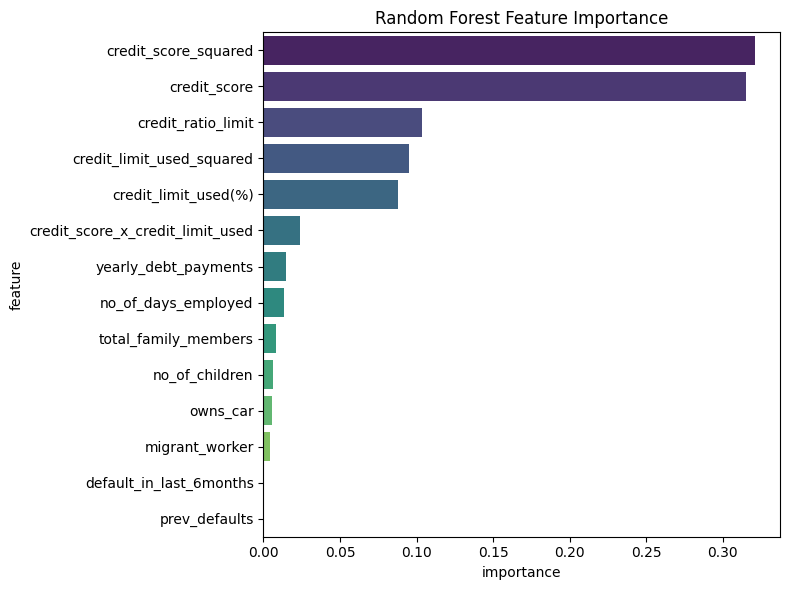

In [8]:
importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": best_rf.feature_importances_
}).sort_values(by="importance", ascending=False)

# Display top features
print(importances)

# Optional: plot
plt.figure(figsize=(8,6))
sns.barplot(data=importances, x="importance", y="feature", palette="viridis")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

In [9]:
plt.figure(figsize=(8,6))
sns.barplot(data=importances, x="importance", y="feature", palette="viridis")
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()

# Save figure
plt.savefig(figures_dir / "rf_feature_importance_recall.png")
plt.close()

# Optional: display in notebook
importances

C:\Users\Trevor\AppData\Local\Temp\ipykernel_5980\2989095679.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances, x="importance", y="feature", palette="viridis")


,feature,importance
10,credit_score_squared,0.321244
1,credit_score,0.315025
13,credit_ratio_limit,0.103661
11,credit_limit_used_squared,0.095161
0,credit_limit_used(%),0.087862
12,credit_score_x_credit_limit_used,0.024141
7,yearly_debt_payments,0.014724
6,no_of_days_employed,0.013284
9,total_family_members,0.008349
4,no_of_children,0.006504


In [10]:
joblib.dump(best_rf, models_dir / "rf_credit_default.pkl")
rf_loaded = joblib.load(models_dir / "rf_credit_default.pkl")